# Analysis of policy residuals

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from lift.environments.simulator import SimulatorFactory
from lift.datasets import (
    load_all_mad_datasets, 
    mad_groupby_labels,
    mad_labels_to_actions,
    mad_augmentation, 
    compute_features, 
)
from configs import BaseConfig

seed = 0
config = BaseConfig()

/Users/ran.w/miniconda3/envs/emg_control/lib/python3.11/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


In [2]:
# load models
bc_trainer = torch.load(config.models_path / "bc.pt")
mi_trainer = torch.load(config.models_path / "mi.pt")
act_dim = bc_trainer.a_dim

encoders = {
    "bc": bc_trainer.encoder,
    "mi": mi_trainer.encoder
}

In [3]:
# generate data
num_samples = 10000

# mad data
mad_windows, mad_labels = load_all_mad_datasets(
    config.mad_base_path.as_posix(),
    num_channels=config.n_channels,
    emg_range=config.emg_range,
    window_size=config.window_size,
    window_overlap=config.window_overlap,
    desired_labels=config.desired_mad_labels,
    skip_person='Female0',
    return_tensors=True,
)
mad_features = compute_features(mad_windows)
mad_actions = mad_labels_to_actions(
    mad_labels, recording_strength=config.simulator.recording_strength,
)

idx = torch.randperm(len(mad_features))[:num_samples]
mad_features = mad_features[idx]
mad_actions = mad_actions[idx]

# aug data
window_list, label_list = mad_groupby_labels(mad_windows, mad_labels)
actions_list = mad_labels_to_actions(
    label_list, recording_strength=config.simulator.recording_strength,
)
aug_windows, aug_actions = mad_augmentation(
    window_list, 
    actions_list, 
    num_samples,
    augmentation_distribution=config.pretrain.augmentation_distribution,
    reduction=config.simulator.reduction,
)
aug_features = compute_features(aug_windows)

# sim data
sim = SimulatorFactory.create_class(
    (config.mad_data_path / "Female0"/ "training0").as_posix(),
    config,
    return_features=True,
)
sim_actions = torch.rand_like(mad_actions).uniform_(-1, 1)
sim_features = sim(sim_actions)

print("mad data size", mad_features.shape, mad_actions.shape)
print("aug data size", aug_features.shape, aug_actions.shape)
print("sim data size", sim_features.shape, sim_actions.shape)

skipping Female0
skipping Female0
skipping Female0
skipping Female0
MAD dataset loaded
mad data size torch.Size([10000, 32]) torch.Size([10000, 3])
aug data size torch.Size([10000, 32]) torch.Size([10000, 3])
sim data size torch.Size([10000, 32]) torch.Size([10000, 3])


In [4]:
# predict
preds = {k: {} for k in encoders.keys()}
for name, encoder in encoders.items():
    with torch.no_grad():
        preds[name]["mad"] = encoder.get_dist(mad_features).mode
        preds[name]["aug"] = encoder.get_dist(aug_features).mode
        preds[name]["sim"] = encoder.get_dist(sim_features).mode

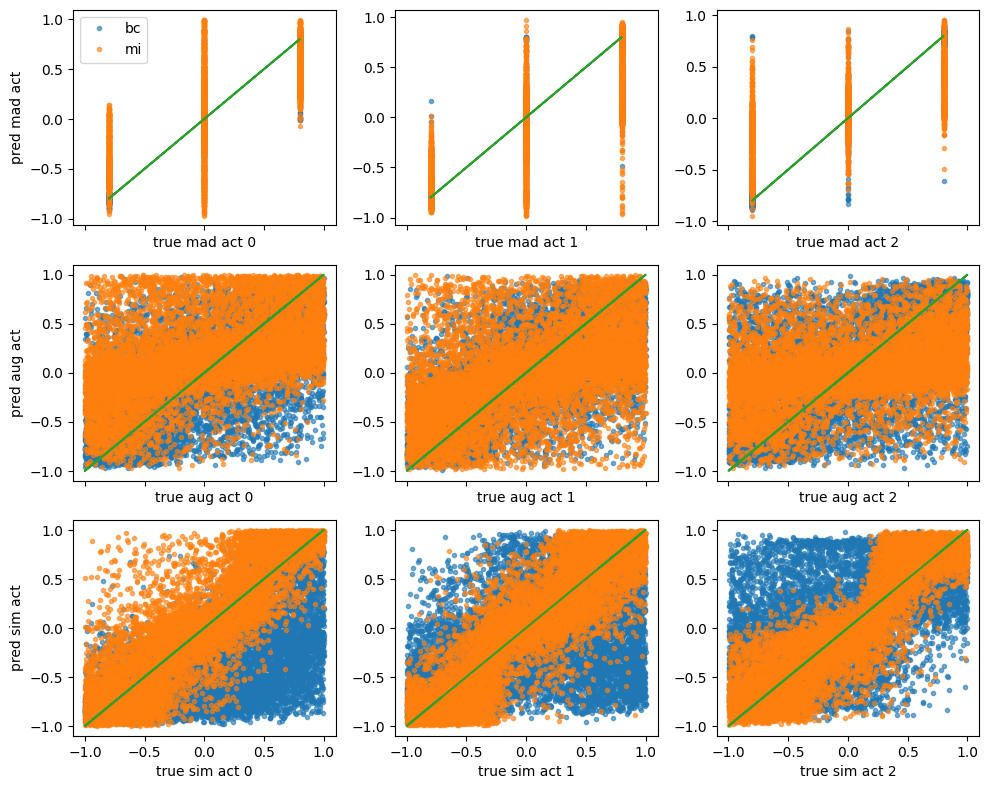

In [5]:
# plot predictions vs true
alpha = 0.6
fig, ax = plt.subplots(3, act_dim, figsize=(10, 8), sharex=True)
for i in range(act_dim):
    ax[0, i].plot(mad_actions[:, i], preds["bc"]["mad"][:, i], ".", alpha=alpha, label="bc")
    ax[0, i].plot(mad_actions[:, i], preds["mi"]["mad"][:, i], ".", alpha=alpha, label="mi")
    ax[0, i].plot(mad_actions[:, i], mad_actions[:, i])

    ax[1, i].plot(aug_actions[:, i], preds["bc"]["aug"][:, i], ".", alpha=alpha, label="bc")
    ax[1, i].plot(aug_actions[:, i], preds["mi"]["aug"][:, i], ".", alpha=alpha, label="mi")
    ax[1, i].plot(aug_actions[:, i], aug_actions[:, i])

    ax[2, i].plot(sim_actions[:, i], preds["bc"]["sim"][:, i], ".", alpha=alpha, label="bc")
    ax[2, i].plot(sim_actions[:, i], preds["mi"]["sim"][:, i], ".", alpha=alpha, label="mi")
    ax[2, i].plot(sim_actions[:, i], sim_actions[:, i])

    ax[0, i].set_xlabel(f"true mad act {i}")
    ax[1, i].set_xlabel(f"true aug act {i}")
    ax[2, i].set_xlabel(f"true sim act {i}")

ax[0, 0].set_ylabel("pred mad act")
ax[1, 0].set_ylabel("pred aug act")
ax[2, 0].set_ylabel("pred sim act")
ax[0, 0].legend()
plt.tight_layout()
plt.show()

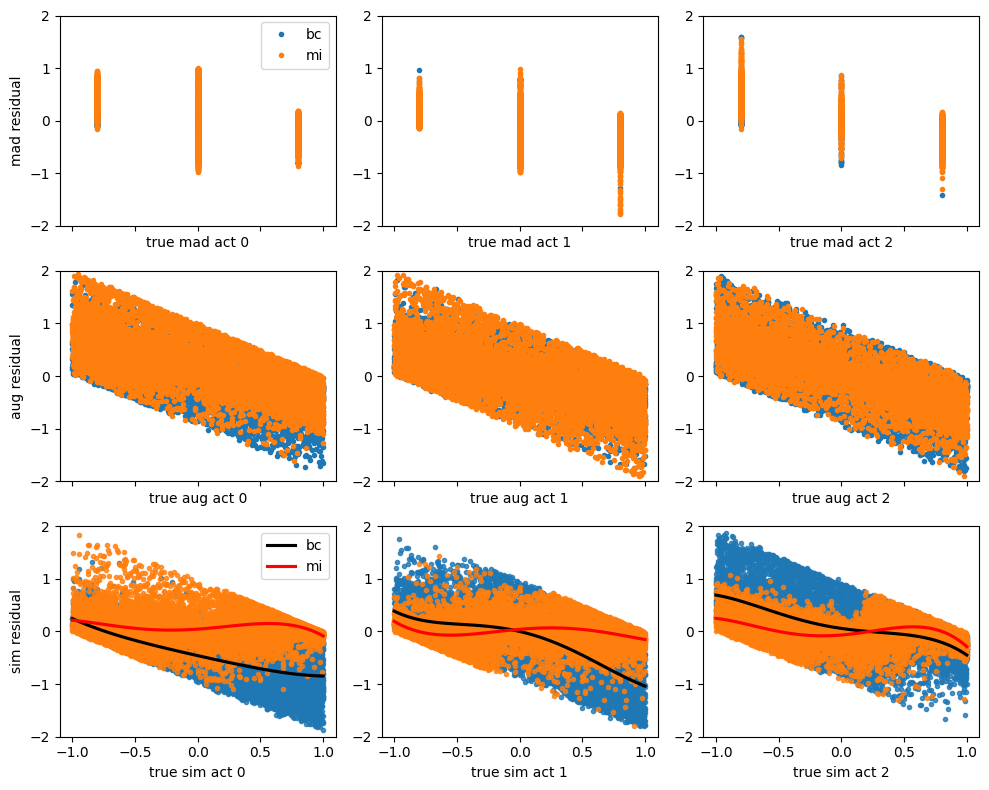

In [6]:
# plot residuals vs true
mad_residuals = {
    "bc": preds["bc"]["mad"] - mad_actions,
    "mi": preds["mi"]["mad"] - mad_actions,
}
aug_residuals = {
    "bc": preds["bc"]["aug"] - aug_actions,
    "mi": preds["mi"]["aug"] - aug_actions,
}
sim_residuals = {
    "bc": preds["bc"]["sim"] - sim_actions,
    "mi": preds["mi"]["sim"] - sim_actions,
}

apply_abs = False
if apply_abs:
    mad_residuals = {k: torch.abs(v) for k, v in mad_residuals.items()}
    aug_residuals = {k: torch.abs(v) for k, v in aug_residuals.items()}
    sim_residuals = {k: torch.abs(v) for k, v in sim_residuals.items()}

fig, ax = plt.subplots(3, act_dim, figsize=(10, 8), sharex=True)
for i in range(act_dim):
    ax[0, i].plot(mad_actions[:, i], mad_residuals["bc"][:, i], ".", label="bc")
    ax[0, i].plot(mad_actions[:, i], mad_residuals["mi"][:, i], ".", label="mi")

    ax[1, i].plot(aug_actions[:, i], aug_residuals["bc"][:, i], ".", label="bc")
    ax[1, i].plot(aug_actions[:, i], aug_residuals["mi"][:, i], ".", label="mi")

    sns.regplot(
        x=sim_actions[:, i].numpy(),
        y=sim_residuals["bc"][:, i].numpy(),
        order=4,
        marker=".",
        line_kws={"color": "k", "label": "bc"},
        ax=ax[2, i],
    )
    sns.regplot(
        x=sim_actions[:, i].numpy(),
        y=sim_residuals["mi"][:, i].numpy(),
        order=4,
        marker=".",
        line_kws={"color": "r", "label": "mi"},
        ax=ax[2, i],
    )

    ax[0, i].set_xlabel(f"true mad act {i}")
    ax[1, i].set_xlabel(f"true aug act {i}")
    ax[2, i].set_xlabel(f"true sim act {i}")

    ax[0, i].set_ylim([-2, 2])
    ax[1, i].set_ylim([-2, 2])
    ax[2, i].set_ylim([-2, 2])

ax[0, 0].set_ylabel("mad residual")
ax[1, 0].set_ylabel("aug residual")
ax[2, 0].set_ylabel("sim residual")
ax[0, 0].legend()
ax[-1, 0].legend()
plt.tight_layout()
plt.show()

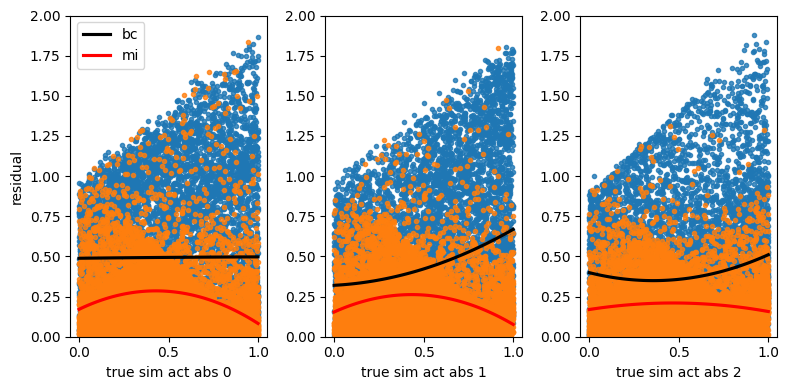

In [7]:
# bc error increase with act magnitude?
fig, ax = plt.subplots(1, act_dim, figsize=(8, 4))
for i in range(act_dim):
    sns.regplot(
        x=sim_actions[:, i].abs().numpy(),
        y=sim_residuals["bc"][:, i].abs().numpy(),
        order=2,
        marker=".",
        line_kws={"color": "k", "label": "bc"},
        ax=ax[i],
    )
    sns.regplot(
        x=sim_actions[:, i].abs().numpy(),
        y=sim_residuals["mi"][:, i].abs().numpy(),
        order=2,
        marker=".",
        line_kws={"color": "r", "label": "mi"},
        ax=ax[i],
    )

    ax[i].set_xlabel(f"true sim act abs {i}")
    ax[i].set_ylim([0, 2])

ax[0].set_ylabel("residual")
ax[0].legend()
plt.tight_layout()
plt.show()

In [8]:
# generate single dim data
num_samples = 3000

dof_preds = [{} for _ in range(act_dim)]
for i in range(act_dim):
    dof_actions = torch.zeros(num_samples, act_dim)
    dof_actions[:, i] = torch.rand(num_samples).uniform_(-1, 1)
    dof_features = sim(dof_actions)

    dof_preds[i]["true"] = dof_actions.clone()
    with torch.no_grad():
        dof_preds[i]["bc"] = encoders["bc"].get_dist(dof_features).mode
        dof_preds[i]["mi"] = encoders["mi"].get_dist(dof_features).mode

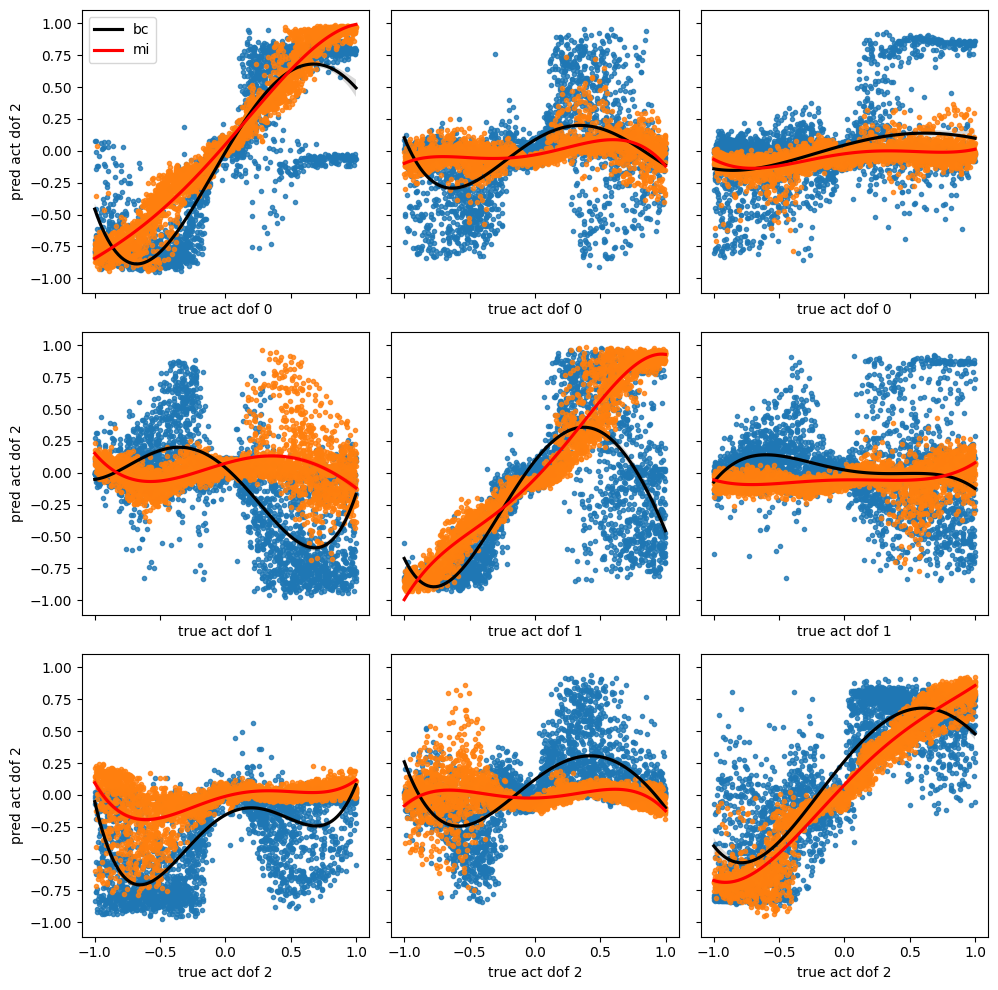

In [9]:
# plot single dof predictions
# always make the ground truth activated dof x axis
fig, ax = plt.subplots(act_dim, act_dim, figsize=(10, 10), sharex=True, sharey=True)
for i in range(act_dim): # sim dof
    for j in range(act_dim):
        sns.regplot(
            x=dof_preds[i]["true"][:, i].numpy(),
            y=dof_preds[i]["bc"][:, j].numpy(),
            order=4,
            marker=".",
            line_kws={"color": "k", "label": "bc"},
            ax=ax[i, j],
        )
        sns.regplot(
            x=dof_preds[i]["true"][:, i].numpy(),
            y=dof_preds[i]["mi"][:, j].numpy(),
            order=4,
            marker=".",
            line_kws={"color": "r", "label": "mi"},
            ax=ax[i, j],
        )

        ax[i, j].set_xlabel(f"true act dof {i}")
        ax[i, 0].set_ylabel(f"pred act dof {j}")

ax[0, 0].legend()
plt.tight_layout()
plt.show()

In [3]:
import random
# create different action groups
action_dict = {}
action_dict['small'] = torch.rand(5_000, 3) * 0.2 - 0.1
action_dict['medium'] = (torch.rand(5_000, 3) / 10 + 0.45) * ((torch.rand(5_000, 3) > 0.5).float() * 2 - 1)
action_dict['large'] = (torch.rand(5_000, 3) / 10 + 0.9) * ((torch.rand(5_000, 3) > 0.5).float() * 2 - 1)

map_1d = torch.eye(3)[torch.randint(0, 3, (5000,))]
action_dict['1dof'] = (torch.rand(5_000, 3) * 2 - 1) * map_1d 

length = 5000
map_2d = torch.zeros(length, 3)
for i in range(length):
    indices = random.sample(range(3), 2)
    map_2d[i, indices] = 1
action_dict['2dof'] = (torch.rand(5_000, 3) * 2 - 1) * map_2d 

action_dict['3dof'] = torch.rand(5_000, 3) * 2 - 1

In [113]:
features_dict = {}
for key, actions in action_dict.items():
    features_dict[key] = sim(actions)

In [114]:
preds = {}
for key, features in features_dict.items():
    preds[key] = {}
    for name, encoder in encoders.items():
        with torch.no_grad():
            preds[key][name] = encoder.sample(features)

In [118]:
heatmap = torch.zeros(len(action_dict), len(encoders)+1)

for i, (key, features) in enumerate(features_dict.items()):
    for j, (name, encoder) in enumerate(encoders.items()):
        heatmap[i, j] = (preds[key][name] - action_dict[key]).abs().mean()

heatmap[:, -1] = heatmap[:, 0] - heatmap[:, 1]

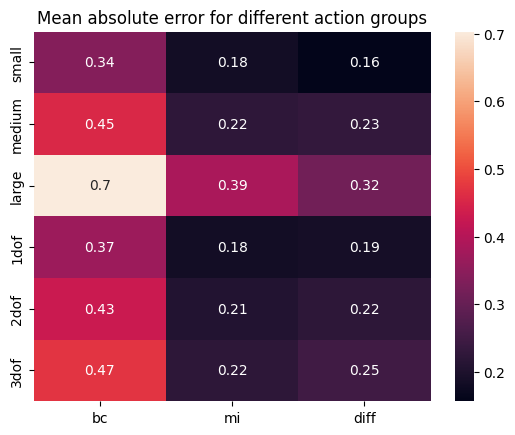

In [119]:
sns.heatmap(heatmap, annot=True, xticklabels=list(encoders.keys())+['diff'], yticklabels=action_dict.keys())
plt.title("Mean absolute error for different action groups")
plt.show()

In [127]:
gt_large_abs = (action_dict['large'].abs() > 0.9).type(torch.float32).mean()
bc_large_abs = (preds['large']['bc'].abs() > 0.9).type(torch.float32).mean()
mi_large_abs = (preds['large']['mi'].abs() > 0.9).type(torch.float32).mean()
print(f"GT large abs: {gt_large_abs:.2f}, BC large abs: {bc_large_abs:.2f}, MI large abs: {mi_large_abs:.2f}")

GT large abs: 1.00, BC large abs: 0.07, MI large abs: 0.07


In [120]:
action_dict['3dof'].abs().mean(), preds['3dof']['bc'].abs().mean(), preds['3dof']['mi'].abs().mean()

(tensor(0.4997), tensor(0.5040), tensor(0.4962))